In [ ]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
b2617bb6d3ffa2e429640350f613e3291e10b141
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [ ]:
import torch
from torchvision import datasets, transforms

# Use torchvision to load Fashion-MNIST dataset
# Use transforms to normalize pixel values, convert to tensors
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)


100%|██████████| 26.4M/26.4M [00:03<00:00, 8.28MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 124kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.22MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.9MB/s]


In [ ]:
# Get train & test sets
train_data = dataset[0]
test_data = dataset[1]

# Use the Subset class to split data into training and validation sets
train_size = 45000
train_data, val_data = torch.utils.data.random_split(dataset, (train_size, len(dataset) - train_size))

# Define transforms for test data (no normalization)
test_transform = transforms.Compose([transforms.ToTensor()])
test_data = datasets.FashionMNIST(root='./data', train=False, transform=test_transform, download=True)


In [ ]:
import torch.nn as nn

# Create MLP network
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = self.out(x)
        return output


In [ ]:
# Create CNN network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        # Dynamically calculate the input size for the first linear layer
        # based on the output of the convolutional layers
        self.fc1 = nn.Linear(self._get_conv_output_size(), 128)
        self.out = nn.Linear(128, 10)

    def _get_conv_output_size(self):
        # Create a dummy tensor to pass through the convolutional layers
        # to determine the output size
        dummy_input = torch.randn(1, 1, 28, 28)
        output = self.pool(self.conv1(dummy_input))
        output = self.pool(torch.relu(self.conv2(output)))
        return output.view(output.size(0), -1).size(1)


    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.pool(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        output = self.out(x)
        return output

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Define hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize models and optimizers
mlp_model = MLP()
cnn_model = CNN()

mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Flatten MLP inputs
            if isinstance(model, MLP):
                inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

        # Validation step
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                if isinstance(model, MLP):
                    inputs = inputs.view(inputs.size(0), -1)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Accuracy: {100 * correct / total}%")

print("Training MLP...")
train_model(mlp_model, train_loader, val_loader, criterion, mlp_optimizer, epochs)

print("\nTraining CNN...")
train_model(cnn_model, train_loader, val_loader, criterion, cnn_optimizer, epochs)

Training MLP...
Epoch 1, Loss: 0.47344769863411784
Validation Accuracy: 83.08666666666667%
Epoch 2, Loss: 0.35131934520111163
Validation Accuracy: 87.29333333333334%
Epoch 3, Loss: 0.31375414253720507
Validation Accuracy: 87.33333333333333%
Epoch 4, Loss: 0.28855420086024836
Validation Accuracy: 88.01333333333334%
Epoch 5, Loss: 0.2692399191543121
Validation Accuracy: 87.80666666666667%
Epoch 6, Loss: 0.2537791508101774
Validation Accuracy: 88.69333333333333%
Epoch 7, Loss: 0.23735863343410363
Validation Accuracy: 89.04%
Epoch 8, Loss: 0.22357989889199167
Validation Accuracy: 88.32%
Epoch 9, Loss: 0.20952152942878788
Validation Accuracy: 89.23333333333333%
Epoch 10, Loss: 0.20245610898762773
Validation Accuracy: 89.58666666666667%

Training CNN...
Epoch 1, Loss: 0.47444239611187106
Validation Accuracy: 87.65333333333334%
Epoch 2, Loss: 0.3165510981872847
Validation Accuracy: 87.7%
Epoch 3, Loss: 0.2723296296740459
Validation Accuracy: 89.66666666666667%
Epoch 4, Loss: 0.242254058248363

Evaluating MLP...
MLP Test Accuracy: 81.07%

Evaluating CNN...
CNN Test Accuracy: 63.17%


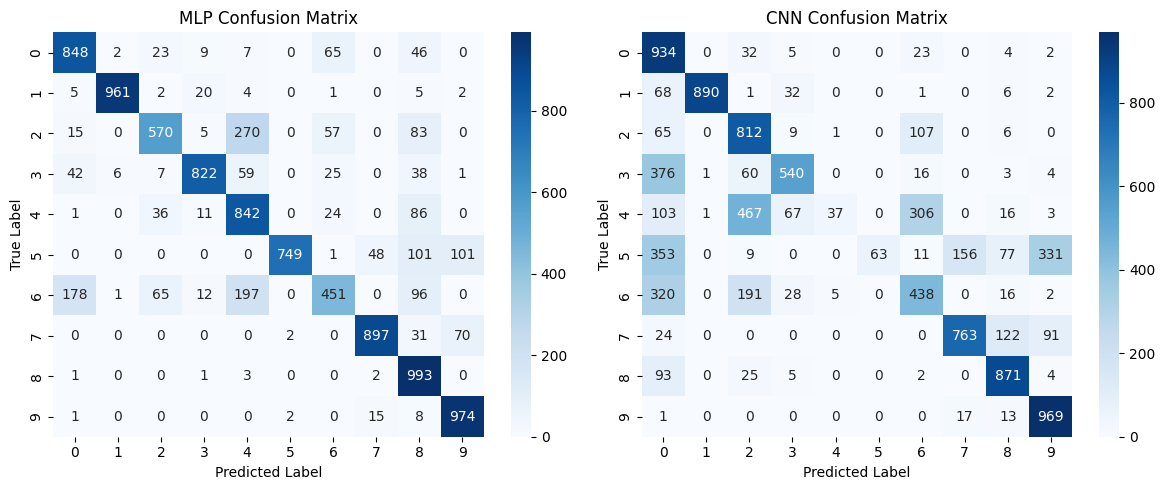

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            if isinstance(model, MLP):
                inputs = inputs.view(inputs.size(0), -1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    accuracy = accuracy_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return accuracy, conf_matrix

# Evaluate MLP
print("Evaluating MLP...")
mlp_accuracy, mlp_conf_matrix = evaluate_model(mlp_model, test_loader)
print(f"MLP Test Accuracy: {mlp_accuracy * 100}%")

# Evaluate CNN
print("\nEvaluating CNN...")
cnn_accuracy, cnn_conf_matrix = evaluate_model(cnn_model, test_loader)
print(f"CNN Test Accuracy: {cnn_accuracy * 100}%")

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("MLP Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("CNN Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn

# Create MLP network
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(0.25) # Added dropout
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.25) # Added dropout
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x) # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x) # Apply dropout
        output = self.out(x)
        return output

In [ ]:
import torch.nn as nn

# Create CNN network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout1 = nn.Dropout(0.25) # Added dropout
        # Dynamically calculate the input size for the first linear layer
        # based on the output of the convolutional layers
        self.fc1 = nn.Linear(self._get_conv_output_size(), 128)
        self.dropout2 = nn.Dropout(0.25) # Added dropout
        self.out = nn.Linear(128, 10)

    def _get_conv_output_size(self):
        # Create a dummy tensor to pass through the convolutional layers
        # to determine the output size
        dummy_input = torch.randn(1, 1, 28, 28)
        output = self.pool(self.conv1(dummy_input))
        output = self.pool(torch.relu(self.conv2(output)))
        return output.view(output.size(0), -1).size(1)


    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.pool(x))
        x = self.dropout1(x) # Apply dropout
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x) # Apply dropout
        output = self.out(x)
        return output

In [ ]:
# Initialize models and optimizers
mlp_model = MLP()
cnn_model = CNN()

mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [ ]:
# Define hyperparameters with different values
batch_size = 128 # Changed from 64
learning_rate = 0.0005 # Changed from 0.001
epochs = 15 # Changed from 20

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Flatten MLP inputs
            if isinstance(model, MLP):
                inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

        # Validation step
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                if isinstance(model, MLP):
                    inputs = inputs.view(inputs.size(0), -1)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Accuracy: {100 * correct / total}%")

print("Training MLP...")
train_model(mlp_model, train_loader, val_loader, criterion, mlp_optimizer, epochs)

print("\nTraining CNN...")
train_model(cnn_model, train_loader, val_loader, criterion, cnn_optimizer, epochs)

Training MLP...
Epoch 1, Loss: 0.5192631630607966
Validation Accuracy: 85.13333333333334%
Epoch 2, Loss: 0.39355065480975265
Validation Accuracy: 86.77333333333333%
Epoch 3, Loss: 0.3615689232141118
Validation Accuracy: 87.05333333333333%
Epoch 4, Loss: 0.34375901394312014
Validation Accuracy: 86.30666666666667%
Epoch 5, Loss: 0.32605921299281443
Validation Accuracy: 87.46666666666667%
Epoch 6, Loss: 0.314545567210933
Validation Accuracy: 87.97333333333333%
Epoch 7, Loss: 0.3047371134214865
Validation Accuracy: 88.41333333333333%
Epoch 8, Loss: 0.29285266509660607
Validation Accuracy: 88.73333333333333%
Epoch 9, Loss: 0.28511788085399364
Validation Accuracy: 88.92%
Epoch 10, Loss: 0.2801341700092466
Validation Accuracy: 88.07333333333334%
Epoch 11, Loss: 0.2683707586468451
Validation Accuracy: 87.55333333333333%
Epoch 12, Loss: 0.26889121965293517
Validation Accuracy: 88.26666666666667%
Epoch 13, Loss: 0.2578862889574587
Validation Accuracy: 88.75333333333333%
Epoch 14, Loss: 0.2542684

Evaluating MLP...
MLP Test Accuracy: 80.31%

Evaluating CNN...
CNN Test Accuracy: 68.71000000000001%


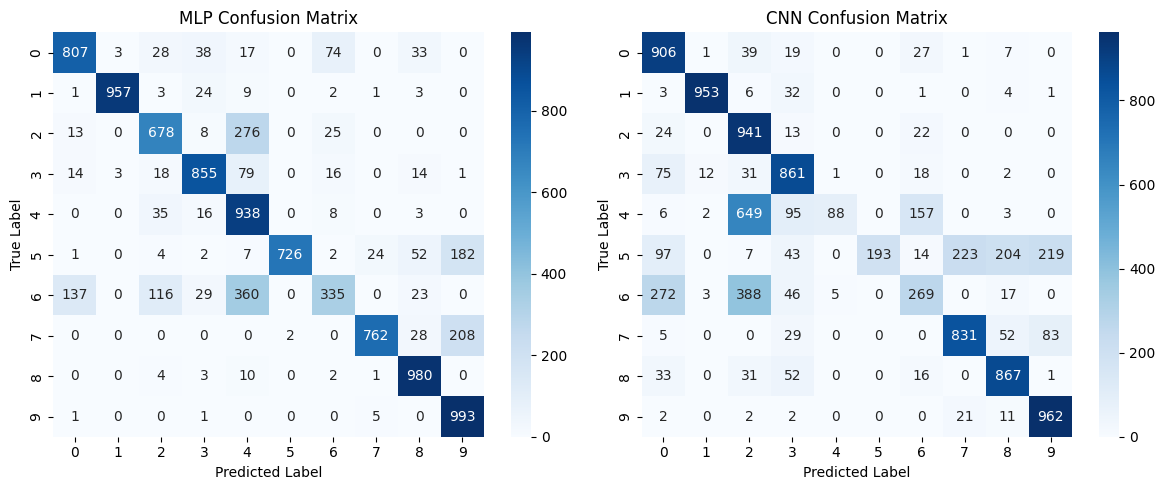

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            if isinstance(model, MLP):
                inputs = inputs.view(inputs.size(0), -1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    accuracy = accuracy_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return accuracy, conf_matrix

# Evaluate MLP
print("Evaluating MLP...")
mlp_accuracy, mlp_conf_matrix = evaluate_model(mlp_model, test_loader)
print(f"MLP Test Accuracy: {mlp_accuracy * 100}%")

# Evaluate CNN
print("\nEvaluating CNN...")
cnn_accuracy, cnn_conf_matrix = evaluate_model(cnn_model, test_loader)
print(f"CNN Test Accuracy: {cnn_accuracy * 100}%")

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("MLP Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("CNN Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()